In [5]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
import ROOT
from numpy.random import normal
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
m=np.array([[4,3,4],[3,2,3],[4,3,4]])
np.argmin(m)

4

In [7]:
!pwd

/home/as111/sipm-analysis


# Coincidence settings

In [8]:
# Coincidence table
# 0000 ---  ---  ---  ---  ---  ---  ---  --- 
# 1000 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0100 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0010 OOO  AOO  ---  ---  ---  ---  ---  ---
# 0001 OOO  AOO  ---  ---  ---  ---  ---  --- 
# 1100 OOO  AOO  OAO  ---  AAO  ---  ---  --- 
# 1010 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 1001 OOO  AOO  OAO  OOA  ---  ---  ---  --- 
# 0110 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0101 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0011 OOO  AOO  OAO  ---  AAO  ---  ---  ---
# 1110 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1101 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1011 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 0111 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 1111 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA 

In [9]:
file_coinc = [  'gamma_1117_65V_top_OOO',
                'gamma_1117_65V_top_AOO',
                'gamma_1117_65V_top_OOA',
                'gamma_1117_65V_top_AAO',
                'gamma_1117_65V_top_OAA',
                'gamma_1115_65V_top_AAA',]
coinc = ['OOO', 'AOO', 'OOA', 'AAO', 'OAA', 'AAA']

In [10]:
ds1117top = []
for i,f in enumerate(file_coinc):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/{}.root".format(f), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        cut = True
        for ch in range(4):
            # dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            # dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut and ev.f_prompt>0.1:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            nev += 1
            
    print('Top 65V {} {} events loaded'.format(coinc[i], nev))
    ds1117top.append(dset)

Top 65V OOO 752328 events loaded
Top 65V AOO 795141 events loaded
Top 65V OOA 184216 events loaded
Top 65V AAO 207257 events loaded
Top 65V OAA 208789 events loaded
Top 65V AAA 98564 events loaded


(0.0, 200.0)

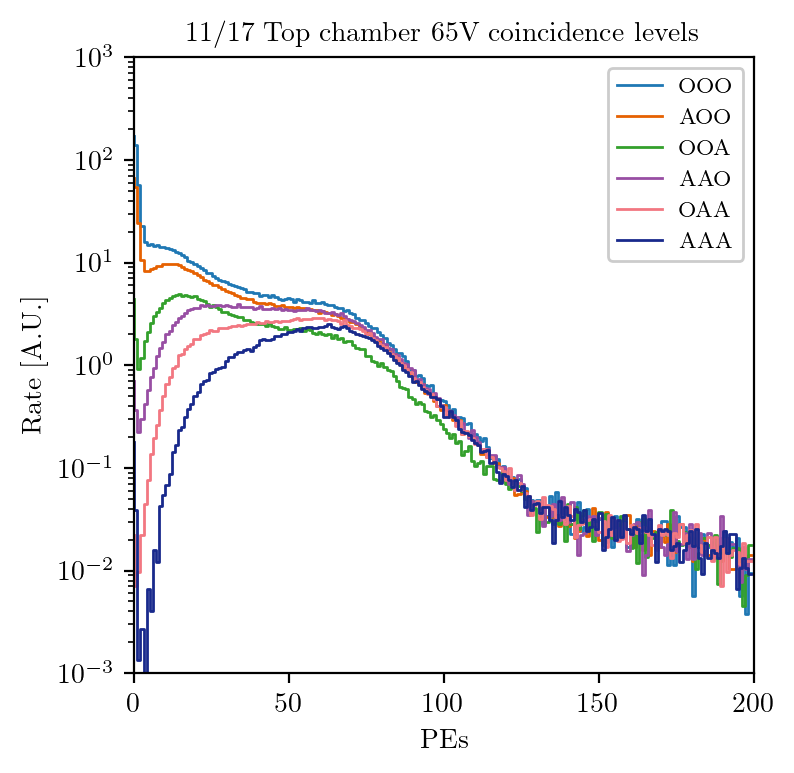

In [11]:
xmin = 0
xmax = 200
nbins = 200
bin_width = (xmax-xmin)/nbins

hist = []
hist_bins = []
plt.figure(0,figsize=(4,4))
for i,dset in enumerate(ds1117top):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
#     h = h/dset.ch[0].cumulative_time/bin_width
    h = h/np.sum(h[int((150-xmin)/bin_width):])
    hist.append(h)
    hist_bins.append(hx)
    plt.step(hx[:-1], h, label=coinc[i], linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/17 Top chamber 65V coincidence levels')
plt.xlim(xmin, xmax)

# Test different bias voltage

In [12]:
bias = [63, 65, 67, 69, 71]

In [13]:
ds1120top = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/gamma_1120_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            
    print('Top {}V {} events loaded'.format(v, nev))
    ds1120top.append(dset)
    
ds1118top_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/backgrounds_1118_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)

    print('Top {}V {} events loaded'.format(v, nev))
    ds1118top_bkg.append(dset)

Top 63V 1003373 events loaded
Top 65V 1007528 events loaded
Top 67V 1016980 events loaded
Top 69V 1014919 events loaded
Top 71V 1015092 events loaded
Top 63V 217218 events loaded
Top 65V 217008 events loaded
Top 67V 218302 events loaded
Top 69V 217576 events loaded
Top 71V 216743 events loaded


## Baseline cut

Text(0, 0.5, 'Count')

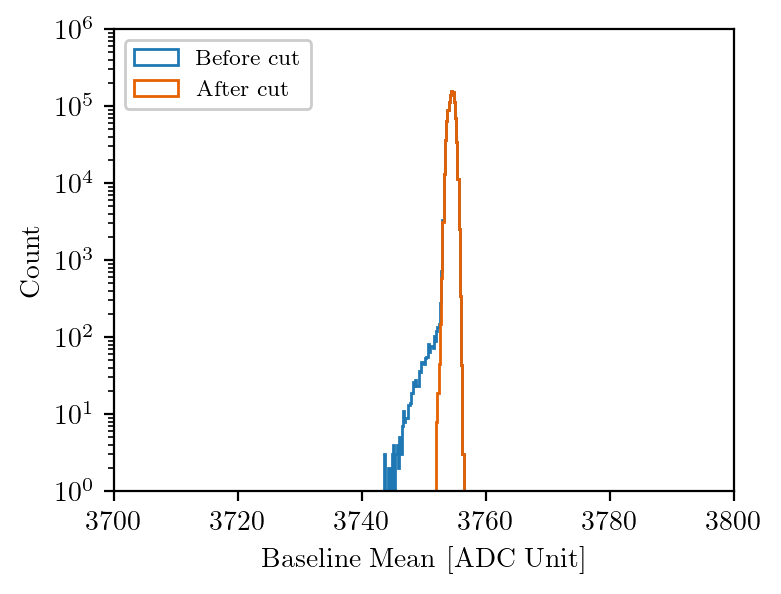

In [14]:
i=0
ch=0
dset = ds1120top[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')

## Fprompt cut

Text(0, 0.5, '$F_{\\rm prompt}$')

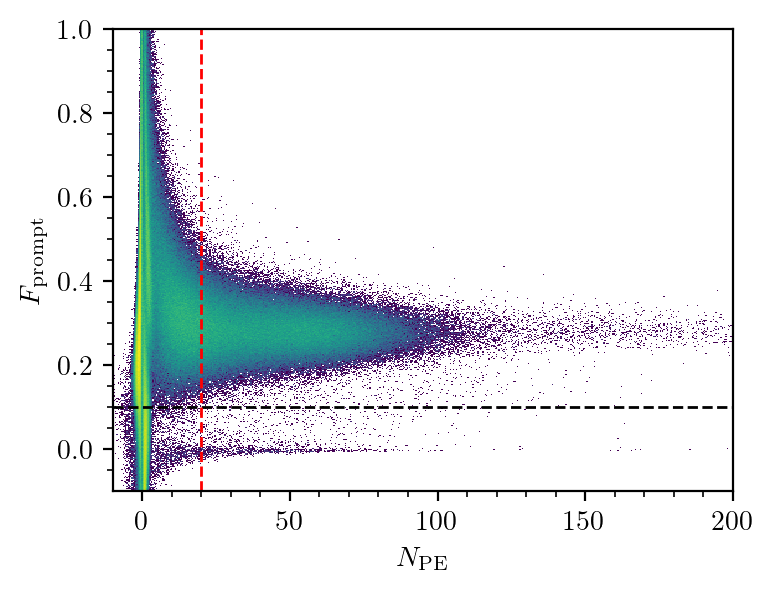

In [15]:
import matplotlib.colors as colors

i=0
dset = ds1120top[i]

nbinsx = 500
range_minx = -10
range_maxx = 200
nbinsy = 500
range_miny = -0.1
range_maxy = 1

fp_cut = 0.1
threshold = 20

plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[np.linspace(range_minx, range_maxx, nbinsx+1), np.linspace(range_miny, range_maxy, nbinsy+1)], norm = colors.LogNorm())
plt.plot([range_minx, range_maxx], [fp_cut]*2, 'k--', linewidth=1)
plt.plot([threshold, threshold], [range_miny, range_maxy], 'r--', linewidth=1)
plt.minorticks_on()
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel(r'$F_{\rm prompt}$')

In [16]:
for i,v in enumerate(bias):
    dset = ds1120top[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut

    dset = ds1118top_bkg[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut


## Draw spectra

(0.0001, 10000000.0)

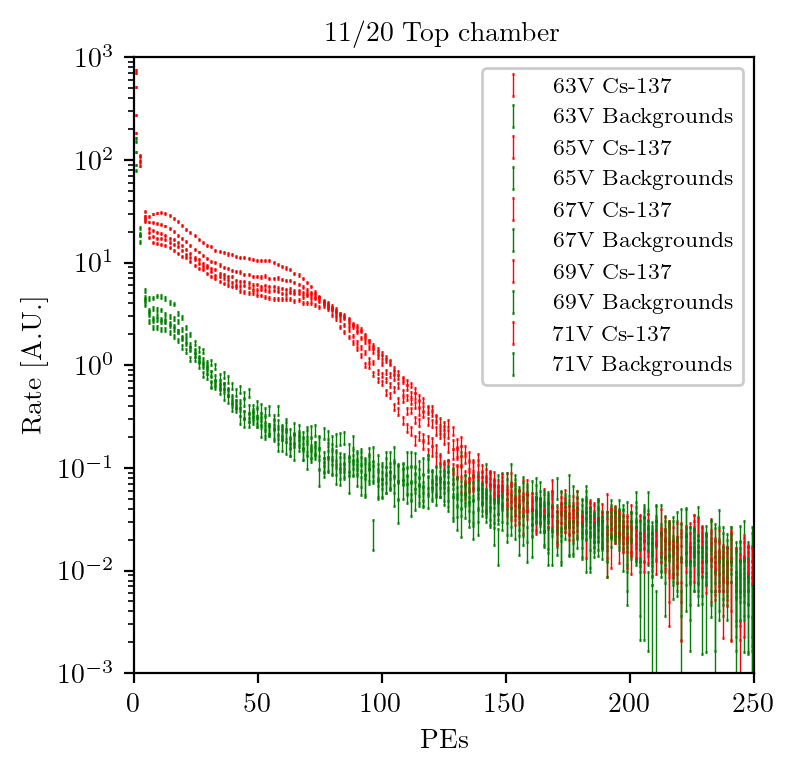

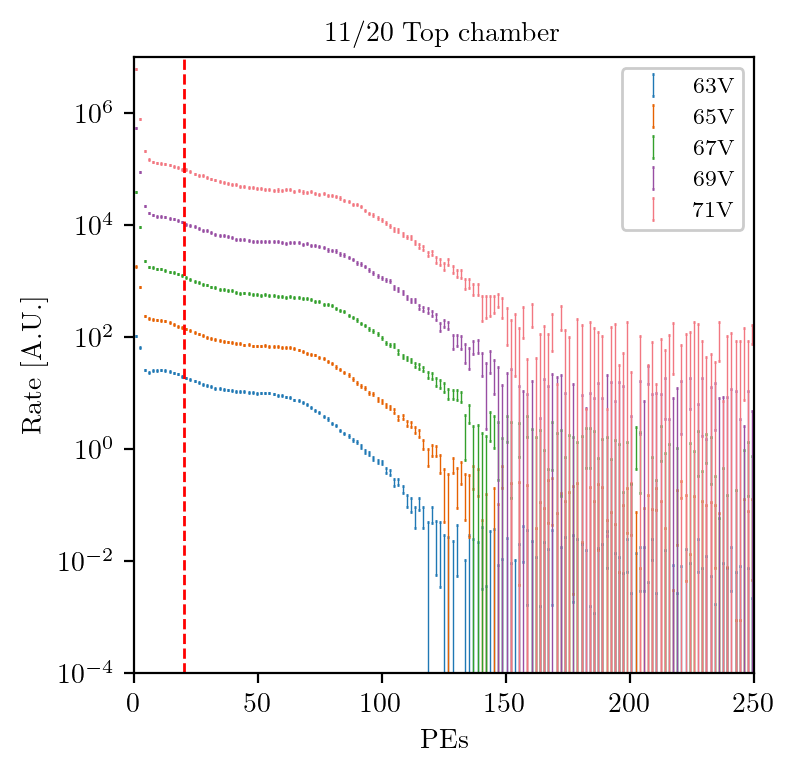

In [17]:
xmin = 0
xmax = 250
nbins = 150
bin_width = (xmax-xmin)/nbins

hist_gamma_top = []
hist_gamma_top_err = []
hist_gamma_top_bins = []
hist_bkg_top = []
hist_bkg_top_err = []
hist_bkg_top_bins = []
hist_dif_top = []
hist_dif_top_err = []
hist_dif_top_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [170, 170, 170, 170, 170]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120top)):
    hg,hgx = np.histogram(ds1120top[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    hist_gamma_top_err.append(np.sqrt(hg))
    norm = np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hg = hg/norm
    hist_gamma_top_err[-1] = hist_gamma_top_err[-1]/norm
    hist_gamma_top.append(hg)
    hist_gamma_top_bins.append(hgx)
    plt.errorbar(0.5*(hgx[1:]+hgx[:-1]), hg, yerr=hist_gamma_top_err[-1], fmt='{}'.format(color[0]), label='{}V {}'.format(bias[i], source[0]), ls='none', capsize=0.5, elinewidth=0.5)

    hb,hbx = np.histogram(ds1118top_bkg[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    hist_bkg_top_err.append(np.sqrt(hb))
    norm = np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hb = hb/norm
    hist_bkg_top_err[-1] = hist_bkg_top_err[-1]/norm
    hist_bkg_top.append(hb)
    hist_bkg_top_bins.append(hbx)
    plt.errorbar(0.5*(hbx[1:]+hbx[:-1]), hb, yerr=hist_bkg_top_err[-1], fmt='{}'.format(color[1]), label='{}V {}'.format(bias[i], source[1]), ls='none', capsize=0.5, elinewidth=0.5)

plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)


plt.figure(1,figsize=(4,4))
ymin = 1e-4
ymax = 1e7
hist_dif_top_bins = hist_gamma_top_bins
for i in range(len(hist_gamma_top)):
    hist_dif_top.append(hist_gamma_top[i]-hist_bkg_top[i])
    hist_dif_top_err.append(np.sqrt(hist_gamma_top_err[i]**2 + hist_bkg_top_err[i]**2))
    plt.errorbar(0.5*(hist_dif_top_bins[i][1:]+hist_dif_top_bins[i][:-1]), hist_dif_top[i]*10**i, yerr=hist_dif_top_err[i]*10**i, label='{}V'.format(bias[i]), ls='none', capsize=0.5, elinewidth=0.5)
plt.plot([threshold,threshold], [ymin,ymax], 'r--', linewidth=1)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Bottom data 11/20

In [18]:
ds1120bot = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/gamma_1120_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            
    print('Bottom {}V {} events loaded'.format(v, nev))
    ds1120bot.append(dset)
    
ds1118bot_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', mode='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("root/backgrounds_1118_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            # dset.ch[ch].baseline_med.append(ev.bsl_med[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            # dset.ch[ch].acquisition_max.append(ev.acq_max[ch])
            # dset.ch[ch].acquisition_min.append(ev.acq_min[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)

    print('Bottom {}V {} events loaded'.format(v, nev))
    ds1118bot_bkg.append(dset)

Bottom 63V 1014166 events loaded
Bottom 65V 1015363 events loaded
Bottom 67V 1015290 events loaded
Bottom 69V 1014591 events loaded
Bottom 71V 1015157 events loaded
Bottom 63V 216580 events loaded
Bottom 65V 216617 events loaded
Bottom 67V 217771 events loaded
Bottom 69V 217350 events loaded
Bottom 71V 218261 events loaded


# Baseline cut

Text(0, 0.5, 'Count')

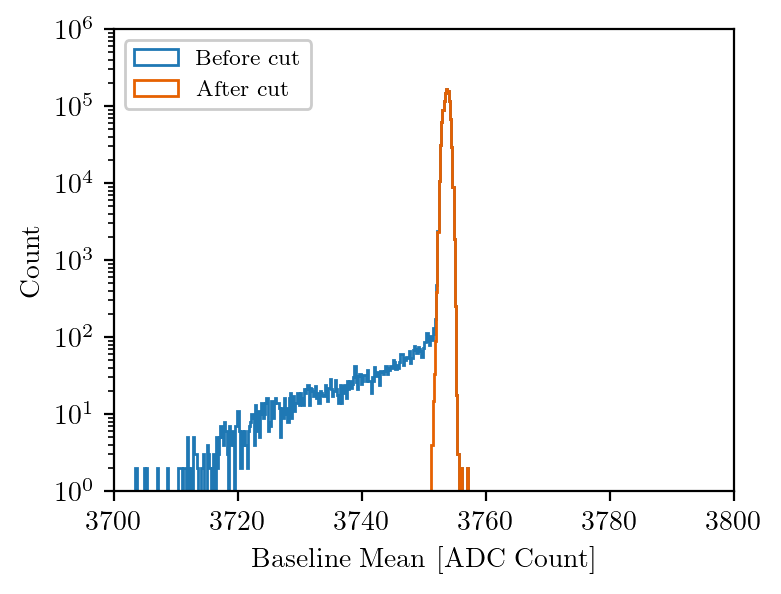

In [19]:
i=0
ch=0
dset = ds1120bot[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.hist(dset.baseline_avg, label='Before cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=np.linspace(range_min, range_max, nbins+1), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Count]')
plt.ylabel('Count')

# Fprompt cut

Text(0, 0.5, '$F_{\\rm prompt}$')

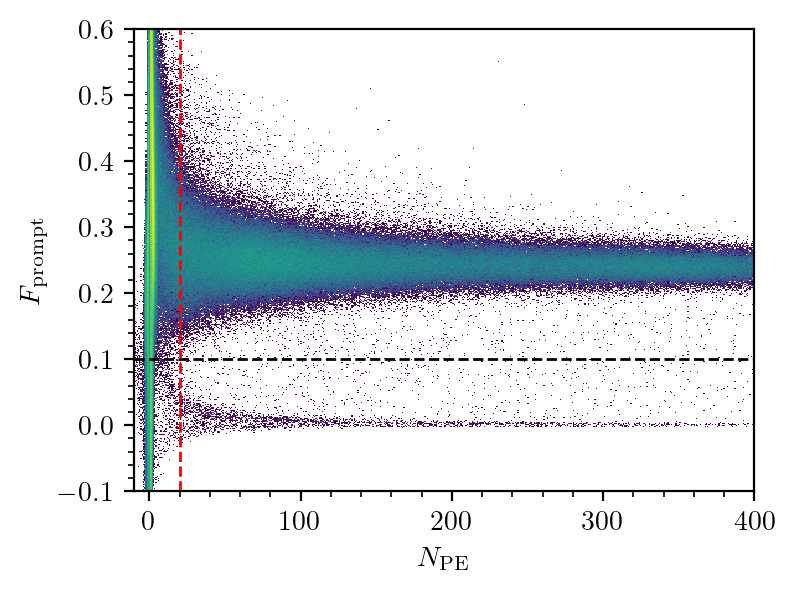

In [20]:
import matplotlib.colors as colors

i=0
dset = ds1120bot[i]

nbinsx = 500
range_minx = -10
range_maxx = 400
nbinsy = 500
range_miny = -0.1
range_maxy = 0.6

fp_cut = 0.1
threshold = 20

plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[np.linspace(range_minx, range_maxx, nbinsx+1), np.linspace(range_miny, range_maxy, nbinsy+1)], norm = colors.LogNorm())
plt.plot([range_minx, range_maxx], [fp_cut]*2, 'k--', linewidth=1)
plt.plot([threshold, threshold], [range_miny, range_maxy], 'r--', linewidth=1)
plt.minorticks_on()
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel(r'$F_{\rm prompt}$')

In [21]:
for i,v in enumerate(bias):
    dset = ds1120bot[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut

    dset = ds1118bot_bkg[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut


## Draw spectra

(0.0, 1200.0)

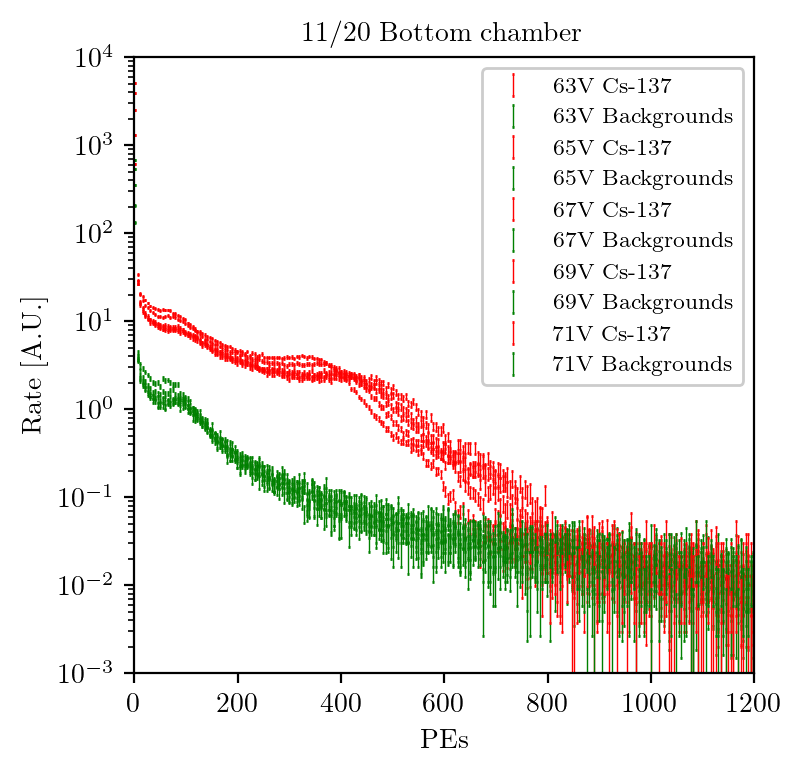

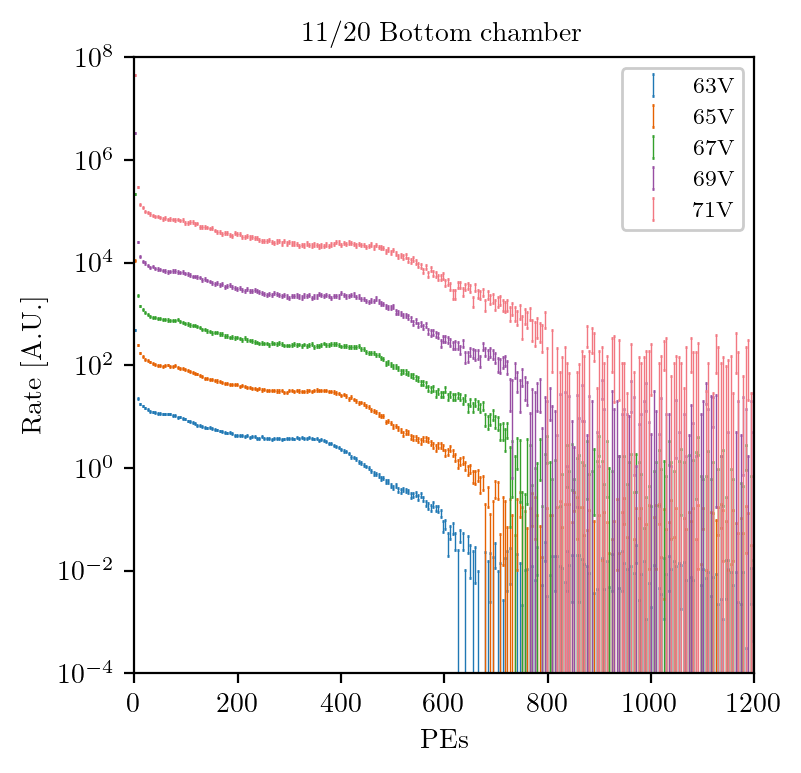

In [138]:
xmin = 0
xmax = 1200
nbins = 250
bin_width = (xmax-xmin)/nbins

hist_gamma_bot = []
hist_gamma_bot_err = []
hist_gamma_bot_bins = []
hist_bkg_bot = []
hist_bkg_bot_err = []
hist_bkg_bot_bins = []
hist_dif_bot = []
hist_dif_bot_err = []
hist_dif_bot_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [900, 900, 900, 900, 900]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120bot)):
    hg,hgx = np.histogram(ds1120bot[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins+1))
    hist_gamma_bot_err.append(np.sqrt(hg))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    norm = np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hg = hg/norm
    hist_gamma_bot_err[i] = hist_gamma_bot_err[i]/norm
    hist_gamma_bot.append(hg)
    hist_gamma_bot_bins.append(hgx)
    plt.errorbar(0.5*(hgx[1:]+hgx[:-1]), hg, yerr=hist_gamma_bot_err[-1], fmt='{}'.format(color[0]), label='{}V {}'.format(bias[i], source[0]), ls='none', capsize=0.5, elinewidth=0.5)

    hb,hbx = np.histogram(ds1118bot_bkg[i].summed_integral_pe, bins=np.linspace(xmin,xmax,nbins+1))
    hist_bkg_bot_err.append(np.sqrt(hb))
    norm = np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hb = hb/norm
    hist_bkg_bot_err[i] = hist_bkg_bot_err[i]/norm
    hist_bkg_bot.append(hb)
    hist_bkg_bot_bins.append(hbx)
    plt.errorbar(0.5*(hbx[1:]+hbx[:-1]), hb, yerr=hist_bkg_bot_err[-1], fmt='{}'.format(color[1]), label='{}V {}'.format(bias[i], source[1]), ls='none', capsize=0.5, elinewidth=0.5)

plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)


plt.figure(1,figsize=(4,4))
hist_dif_bot_bins = hist_gamma_bot_bins
for i in range(len(hist_gamma_bot)):
    hist_dif_bot.append(hist_gamma_bot[i]-hist_bkg_bot[i])
    hist_dif_bot_err.append(np.sqrt(hist_gamma_bot_err[i]**2 + hist_bkg_bot_err[i]**2))
    plt.errorbar(0.5*(hist_dif_bot_bins[i][1:]+hist_dif_bot_bins[i][:-1]), hist_dif_bot[i]*10**i, yerr=hist_dif_bot_err[i]*10**i, label='{}V'.format(bias[i]), ls='none', capsize=0.5, elinewidth=0.5)
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel('PEs')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)

# Chi-square maps
## In 2D, 68% is 1.515 sigma.

In [160]:
from scipy.stats import multivariate_normal

def gauss2d(xy, ly, fano, Sx, Sy, theta, c):
    sxx = Sx**2*np.cos(theta)**2+Sy**2*np.sin(theta)**2
    sxy = (Sx**2-Sy**2)*np.sin(theta)*np.cos(theta)
    syy = Sx**2*np.sin(theta)**2+Sy**2*np.cos(theta)**2
    return -2*np.log(2*np.pi*Sx*Sy*multivariate_normal(mean=[ly,fano], cov=[[sxx, sxy],[sxy, syy]]).pdf(xy))+c

In [161]:
def chisquare_two_hist(ly, fano, data_hist, data_hist_bins, data_hist_err, tree, range_pe):
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
#     print(np.shape(data_hist), np.shape(data_hist_bins), np.shape(data_hist_err))
    
    simulated_pe = []
    for i,ev in enumerate(tree):
        simulated_pe.append(normal(ly*ev.Edep, np.sqrt(fano*ly*ev.Edep)))
    hSimPE, hSimPE_bins = np.histogram(simulated_pe, bins=np.linspace(xmin,xmax,nbins+1))
    hSimPE_err = np.sqrt(hSimPE)
#     print(np.shape(hSimPE), np.shape(hSimPE_bins), np.shape(hSimPE_err))
    simulated_pe = []
    range_bin = [int((range_pe[0]-xmin)/bin_width), int((range_pe[1]-xmin)/bin_width)]
    norm_sim = np.sum(data_hist[range_bin[0]:range_bin[1]])/np.sum(hSimPE[range_bin[0]:range_bin[1]])
    hSimPE = hSimPE*norm_sim
    hSimPE_err = hSimPE_err*norm_sim
    chi_square = 0
    for i in range(range_bin[0], range_bin[1]):
        chi_square += (data_hist[i] - hSimPE[i])**2/((data_hist_err[i])**2 + (hSimPE_err[i])**2)
    dof = range_bin[1]-range_bin[0] - 4
    print(ly, fano, chi_square, dof)
    return chi_square

# Top

0.16 1.0 371.80586535873954 56
0.16077777777777777 1.0 281.9267944336822 56
0.16155555555555556 1.0 263.155280402134 56
0.16233333333333333 1.0 231.18834955846305 56
0.16311111111111112 1.0 175.45288837672243 56
0.1638888888888889 1.0 137.74728687292873 56
0.16466666666666668 1.0 160.55083279824427 56
0.16544444444444445 1.0 141.73355220605785 56
0.16622222222222224 1.0 98.70722481320645 56
0.167 1.0 156.6451066913928 56
0.16 1.1666666666666667 248.25371183310162 56
0.16077777777777777 1.1666666666666667 192.94158570540037 56
0.16155555555555556 1.1666666666666667 178.35267395339662 56
0.16233333333333333 1.1666666666666667 136.97121982572327 56
0.16311111111111112 1.1666666666666667 119.9298349727774 56
0.1638888888888889 1.1666666666666667 86.91330634097062 56
0.16466666666666668 1.1666666666666667 84.66749205764214 56
0.16544444444444445 1.1666666666666667 77.91421416385788 56
0.16622222222222224 1.1666666666666667 105.51064277793184 56
0.167 1.1666666666666667 101.40314616799417 56

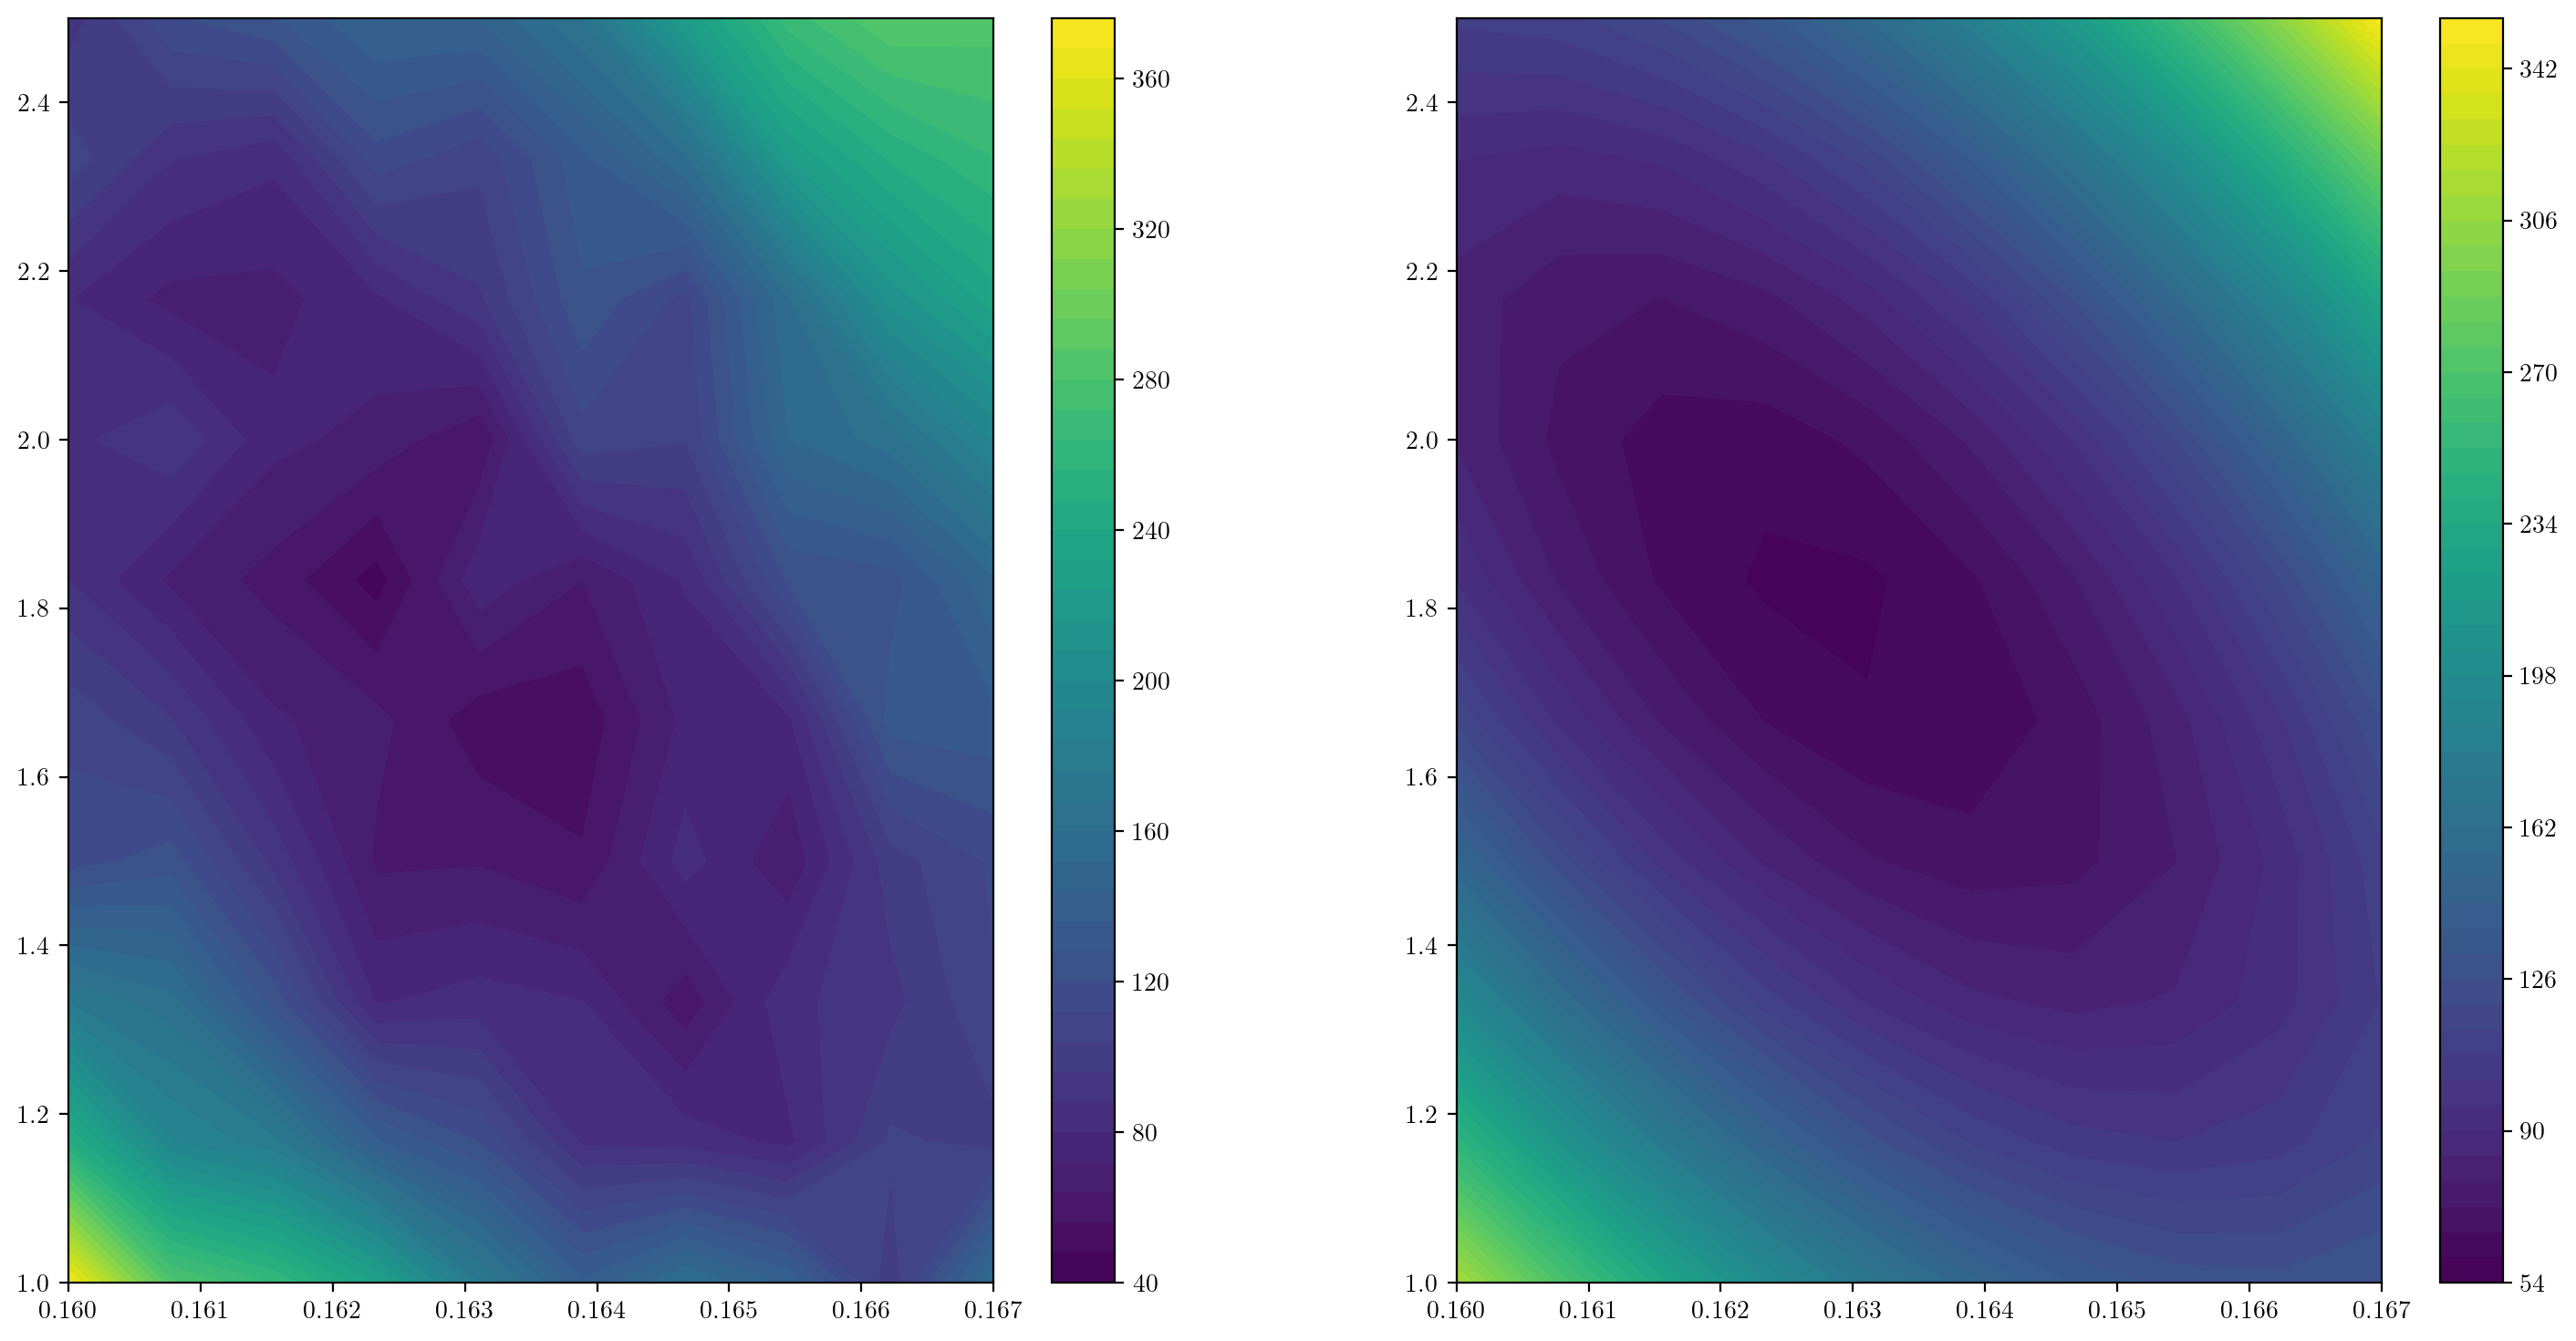

Ly=0.163+/-0.001 PE/keV  F=1.808+/-0.147 (68% CL)


In [162]:
# TOP CHAMBER
data_hist = hist_dif_top[2]
data_hist_bins = hist_dif_top_bins[2]
data_hist_err = hist_dif_top_err[2]

# G4DS SIMULATION
file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")
# file.Close()

# (Ly,F) range
lys = np.linspace(0.160, 0.167, 10)
fanos = np.linspace(1, 2.5, 10)
X,Y = np.meshgrid(lys, fanos)

fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(18,9)

# Spectrum fit range
norm_min = 50
norm_max = 150
chi2map = np.array([[chisquare_two_hist(ly_, fano_, data_hist, data_hist_bins, data_hist_err, tr, [norm_min,norm_max]) for ly_ in lys] for fano_ in fanos])
cp=ax1.contourf(X, Y, chi2map, 50)
fig.colorbar(cp) # Add a colorbar to a plot
file.Close()

# Fit chi-square to find minimum and errors
popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[0.163, 1.8, 0.0005, 0.1, 0.004, 57], maxfev=10000)
print(*popt)
cp=ax2.contourf(X, Y, gauss2d(np.dstack((X,Y)),*popt), 50)
fig.colorbar(cp)
plt.show()

# Print best fit values and 68% CL
ly_fit = popt[0]
fano_fit = popt[1]
ly_68 = 1.515*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
fano_68 = 1.515*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
print('Ly={:.3f}+/-{:.3f} PE/keV  F={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, fano_fit, fano_68))

174324 events simulated


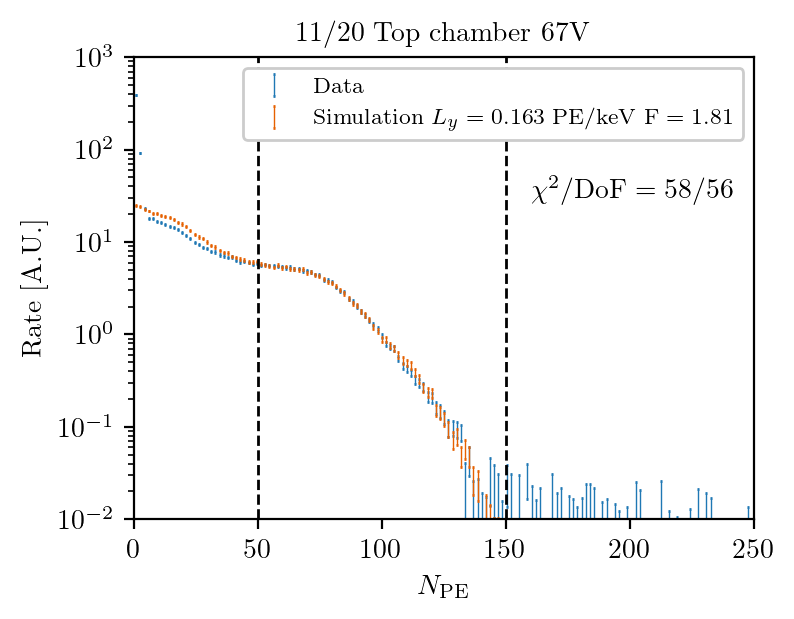

In [164]:
# TOP CHAMBER
data_hist = hist_dif_top[2]
data_hist_bins = hist_dif_top_bins[2]
data_hist_err = hist_dif_top_err[2]

# G4DS SIMULATION
file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")

simPE = []
nev = 0
for i,ev in enumerate(tr):
    for j in range(1):
        simPE.append(normal(ly_fit*tr.Edep, np.sqrt(fano_fit*ly_fit*tr.Edep)))
        nev += 1
print('{} events simulated'.format(nev))
file.Close()

ymin = 1e-2
ymax = 1e3
xmin = data_hist_bins[0]
xmax = data_hist_bins[-1]
nbins = len(data_hist_bins)-1
bin_width = (xmax-xmin)/nbins
hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
hSimErr = np.sqrt(hSim)
norm = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
hSim = hSim*norm
hSimErr = hSimErr*norm
plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, label='Data', ls='none', capsize=0.5, elinewidth=0.5)
plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}~\rm PE/keV~F={:.2f}$'.format(ly_fit, fano_fit), ls='none', capsize=0.5, elinewidth=0.5)
plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
plt.text(160, 3e1, r'$\chi^2/\rm DoF={:.0f}/{:.0f}$'.format(popt[-1],(norm_max-norm_min)/bin_width-4))
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber 67V')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
file.Close()

Running for top 63V
0.13999999999999999 1.0 126.55874154823125 56
0.14066666666666666 1.0 91.87135080165304 56
0.1413333333333333 1.0 82.12516959116999 56
0.142 1.0 83.05161602661742 56
0.14266666666666666 1.0 115.98418221153693 56
0.1433333333333333 1.0 106.19762095160134 56
0.144 1.0 126.71667428472698 56
0.14466666666666667 1.0 165.72509383510203 56
0.14533333333333331 1.0 197.71257956717565 56
0.146 1.0 224.11280933025643 56
0.13999999999999999 1.1666666666666667 67.05875052733901 56
0.14066666666666666 1.1666666666666667 101.96899104851408 56
0.1413333333333333 1.1666666666666667 79.45409938124801 56
0.142 1.1666666666666667 86.31651012166502 56
0.14266666666666666 1.1666666666666667 71.19117097832411 56
0.1433333333333333 1.1666666666666667 125.51834212605009 56
0.144 1.1666666666666667 136.8195170970283 56
0.14466666666666667 1.1666666666666667 184.1491181159653 56
0.14533333333333331 1.1666666666666667 233.8080241137174 56
0.146 1.1666666666666667 232.0621667619861 56
0.1399999

/tmp/ipykernel_2484164/3086760263.py:7: RuntimeWarning: divide by zero encountered in log
  return -2*np.log(2*np.pi*Sx*Sy*multivariate_normal(mean=[ly,fano], cov=[[sxx, sxy],[sxy, syy]]).pdf(xy))+c


174324 events simulated
Running for top 65V
0.15 1.0 259.72189218594986 56
0.15066666666666667 1.0 208.52426378360215 56
0.15133333333333332 1.0 174.7009116993458 56
0.152 1.0 147.3403229951952 56
0.15266666666666667 1.0 137.40594846051465 56
0.15333333333333332 1.0 123.4383115507101 56
0.154 1.0 106.31934536196658 56
0.15466666666666667 1.0 125.8428521567733 56
0.15533333333333332 1.0 136.63431173289405 56
0.156 1.0 132.25349397784044 56
0.15 1.1666666666666667 192.58190034152244 56
0.15066666666666667 1.1666666666666667 151.92918026976253 56
0.15133333333333332 1.1666666666666667 142.345638163097 56
0.152 1.1666666666666667 111.2707760947659 56
0.15266666666666667 1.1666666666666667 106.3602724770441 56
0.15333333333333332 1.1666666666666667 79.41288829026317 56
0.154 1.1666666666666667 101.04638049804439 56
0.15466666666666667 1.1666666666666667 97.04379059634763 56
0.15533333333333332 1.1666666666666667 106.3882949972371 56
0.156 1.1666666666666667 138.20769791360706 56
0.15 1.3333

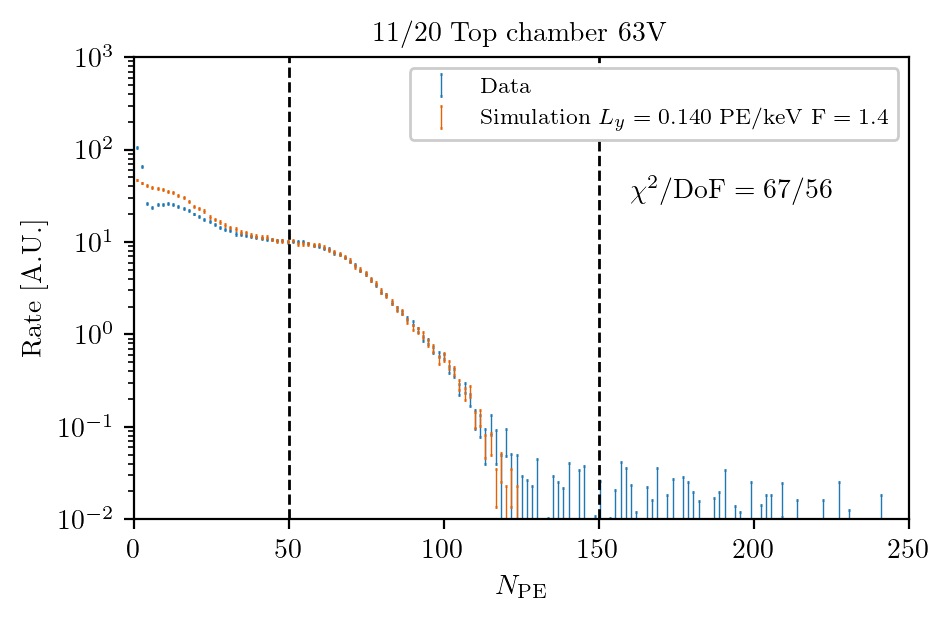

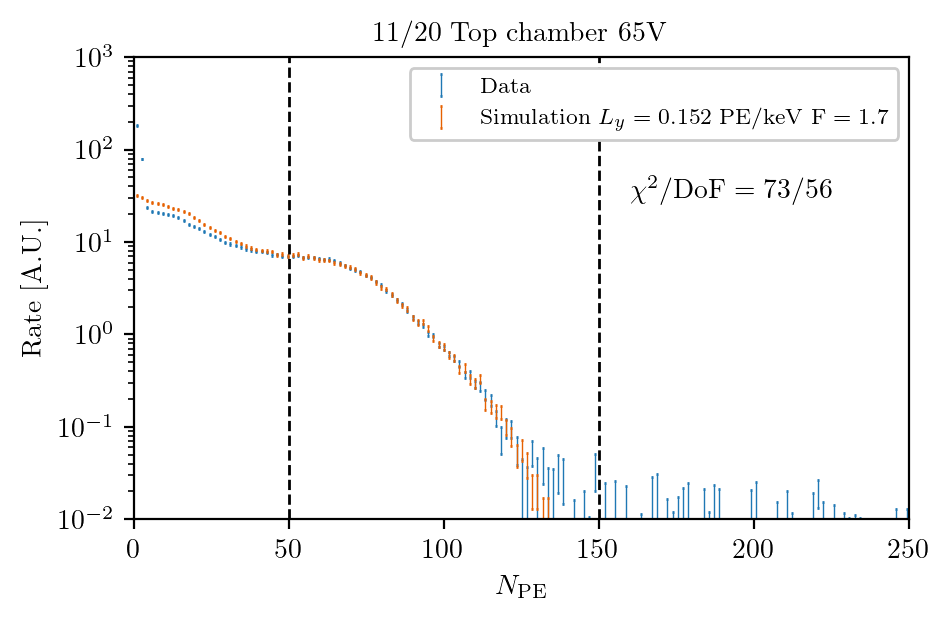

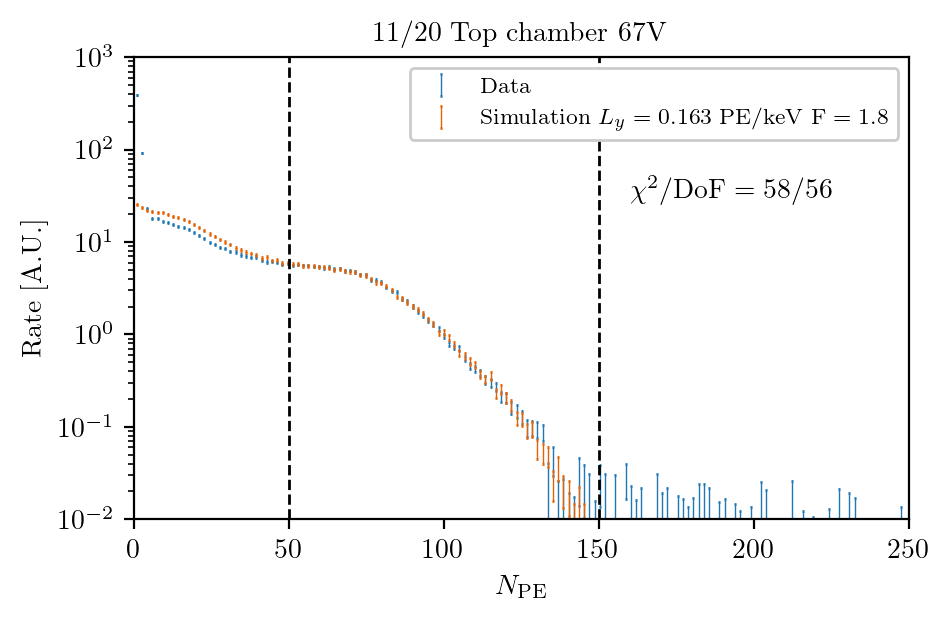

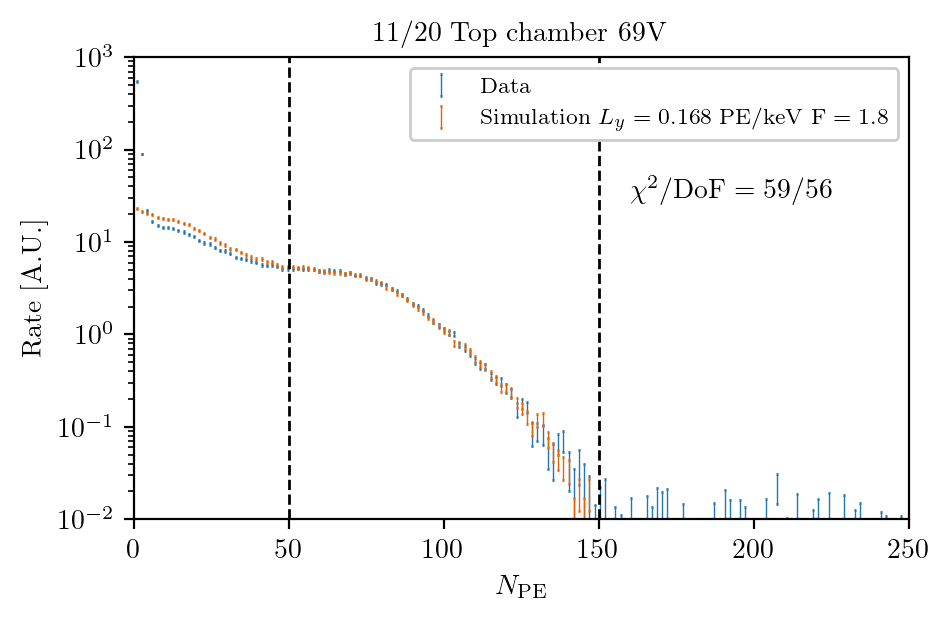

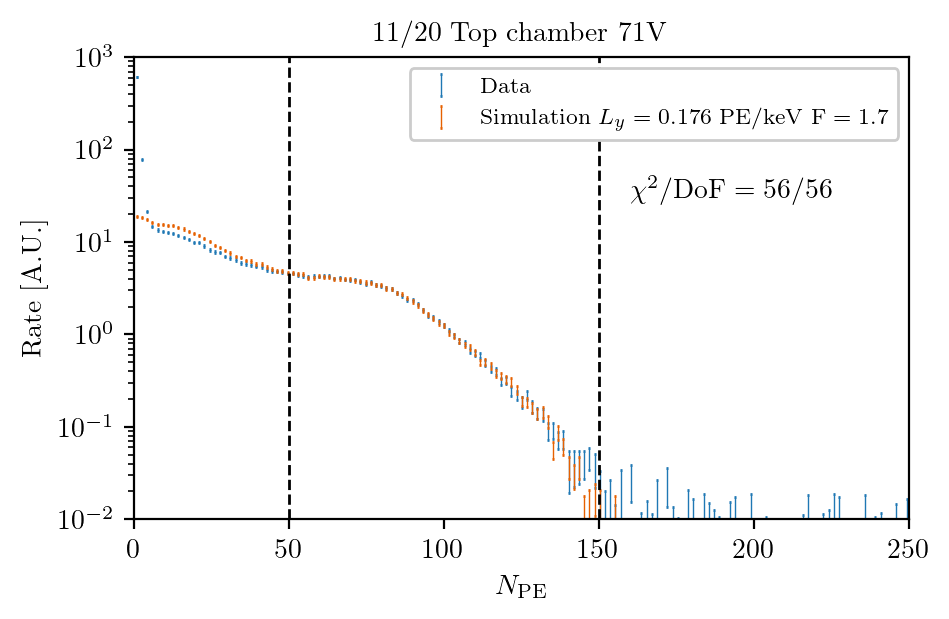

In [165]:
ly_guess = [0.143, 0.153, 0.163, 0.173, 0.183]
ly_top = []
fano_top = []
for iv,volt in enumerate(bias):
    print('Running for top {}V'.format(volt))
    data_hist = hist_dif_top[iv]
    data_hist_bins = hist_dif_top_bins[iv]
    data_hist_err = hist_dif_top_err[iv]

    file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
    tr = file.Get("trEdep")

    lys = np.linspace(ly_guess[iv]-0.003, ly_guess[iv]+0.003, 10)
    fanos = np.linspace(1, 2.5, 10)
    X,Y = np.meshgrid(lys, fanos)

    # Spectrum fit range
    norm_min = 50
    norm_max = 150
    chi2map = np.array([[chisquare_two_hist(ly_, fano_, data_hist, data_hist_bins, data_hist_err, tr, [norm_min,norm_max]) for ly_ in lys] for fano_ in fanos])

    # Fit chi-square to find minimum and errors
    popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[ly_guess[iv], 1.8, 0.0005, 0.1, 0.004, 57], maxfev=10000)

    # Print best fit values and 68% CL
    ly_fit = popt[0]
    fano_fit = popt[1]
    ly_68 = 1.515*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
    fano_68 = 1.515*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
    print('Ly={:.3f}+/-{:.3f} PE/keV  F={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, fano_fit, fano_68))
    ly_top.append([ly_fit, ly_68])
    fano_top.append([fano_fit, fano_68])
    
    simPE = []
    nev = 0
    for i,ev in enumerate(tr):
        for j in range(1):
            simPE.append(normal(ly_fit*tr.Edep, np.sqrt(fano_fit*ly_fit*tr.Edep)))
            nev += 1
    print('{} events simulated'.format(nev))
    file.Close()

    ymin = 1e-2
    ymax = 1e3
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
    hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
    hSimErr = np.sqrt(hSim)
    norm = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
    hSim = hSim*norm
    hSimErr = hSimErr*norm
    plt.figure(iv,figsize=(5,3))
    plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, label='Data', ls='none', capsize=0.5, elinewidth=0.5)
    plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}~\rm PE/keV~F={:.1f}$'.format(ly_fit, fano_fit), ls='none', capsize=0.5, elinewidth=0.5)
    plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
    plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
    plt.text(160, 3e1, r'$\chi^2/\rm DoF={:.0f}/{:.0f}$'.format(popt[-1],(norm_max-norm_min)/bin_width-4))
    plt.yscale('log')
    plt.ylabel('Rate [A.U.]')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.legend(loc='upper right')
    plt.title('11/20 Top chamber {}V'.format(volt))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

Text(0.5, 0.98, 'Top')

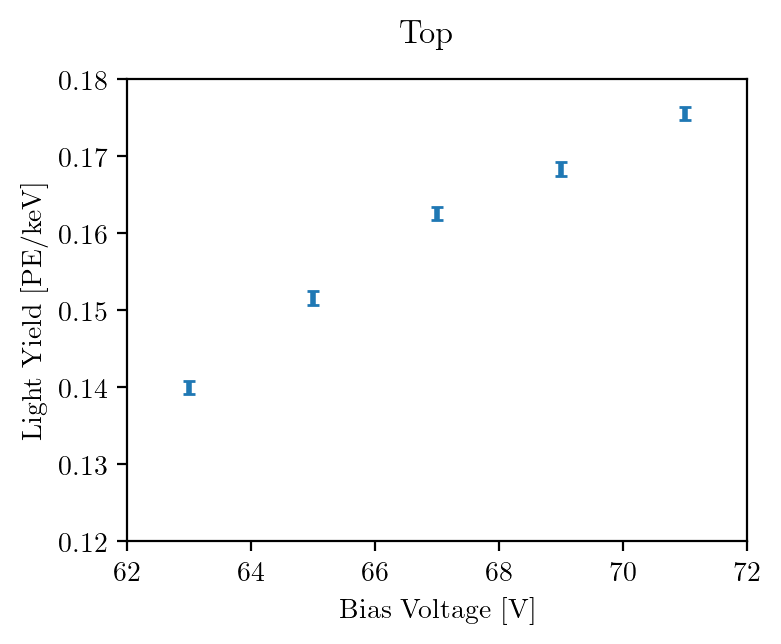

In [166]:
plt.errorbar(bias,np.array(ly_top)[:,0],yerr=np.array(ly_top)[:,1], ls='none', elinewidth=2, capsize=2)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.xlim(62,72)
plt.ylim(0.12,0.18)
plt.suptitle('Top')

# Bottom

0.93 2.0 359.95548203008076 121
0.9344444444444445 2.0 323.6741879791155 121
0.9388888888888889 2.0 271.8912317445875 121
0.9433333333333334 2.0 267.99984890095425 121
0.9477777777777778 2.0 215.44518015843687 121
0.9522222222222222 2.0 224.3420481518817 121
0.9566666666666667 2.0 213.95317585504304 121
0.9611111111111111 2.0 206.17280371436848 121
0.9655555555555555 2.0 228.38327948279823 121
0.97 2.0 234.813496078534 121
0.93 2.4444444444444446 262.23728342404354 121
0.9344444444444445 2.4444444444444446 255.95526658349306 121
0.9388888888888889 2.4444444444444446 211.18920268628364 121
0.9433333333333334 2.4444444444444446 182.3718396336269 121
0.9477777777777778 2.4444444444444446 181.5167155088949 121
0.9522222222222222 2.4444444444444446 203.10914394112427 121
0.9566666666666667 2.4444444444444446 198.15194064355816 121
0.9611111111111111 2.4444444444444446 163.30520080259487 121
0.9655555555555555 2.4444444444444446 214.31907817390567 121
0.97 2.4444444444444446 255.512890394595

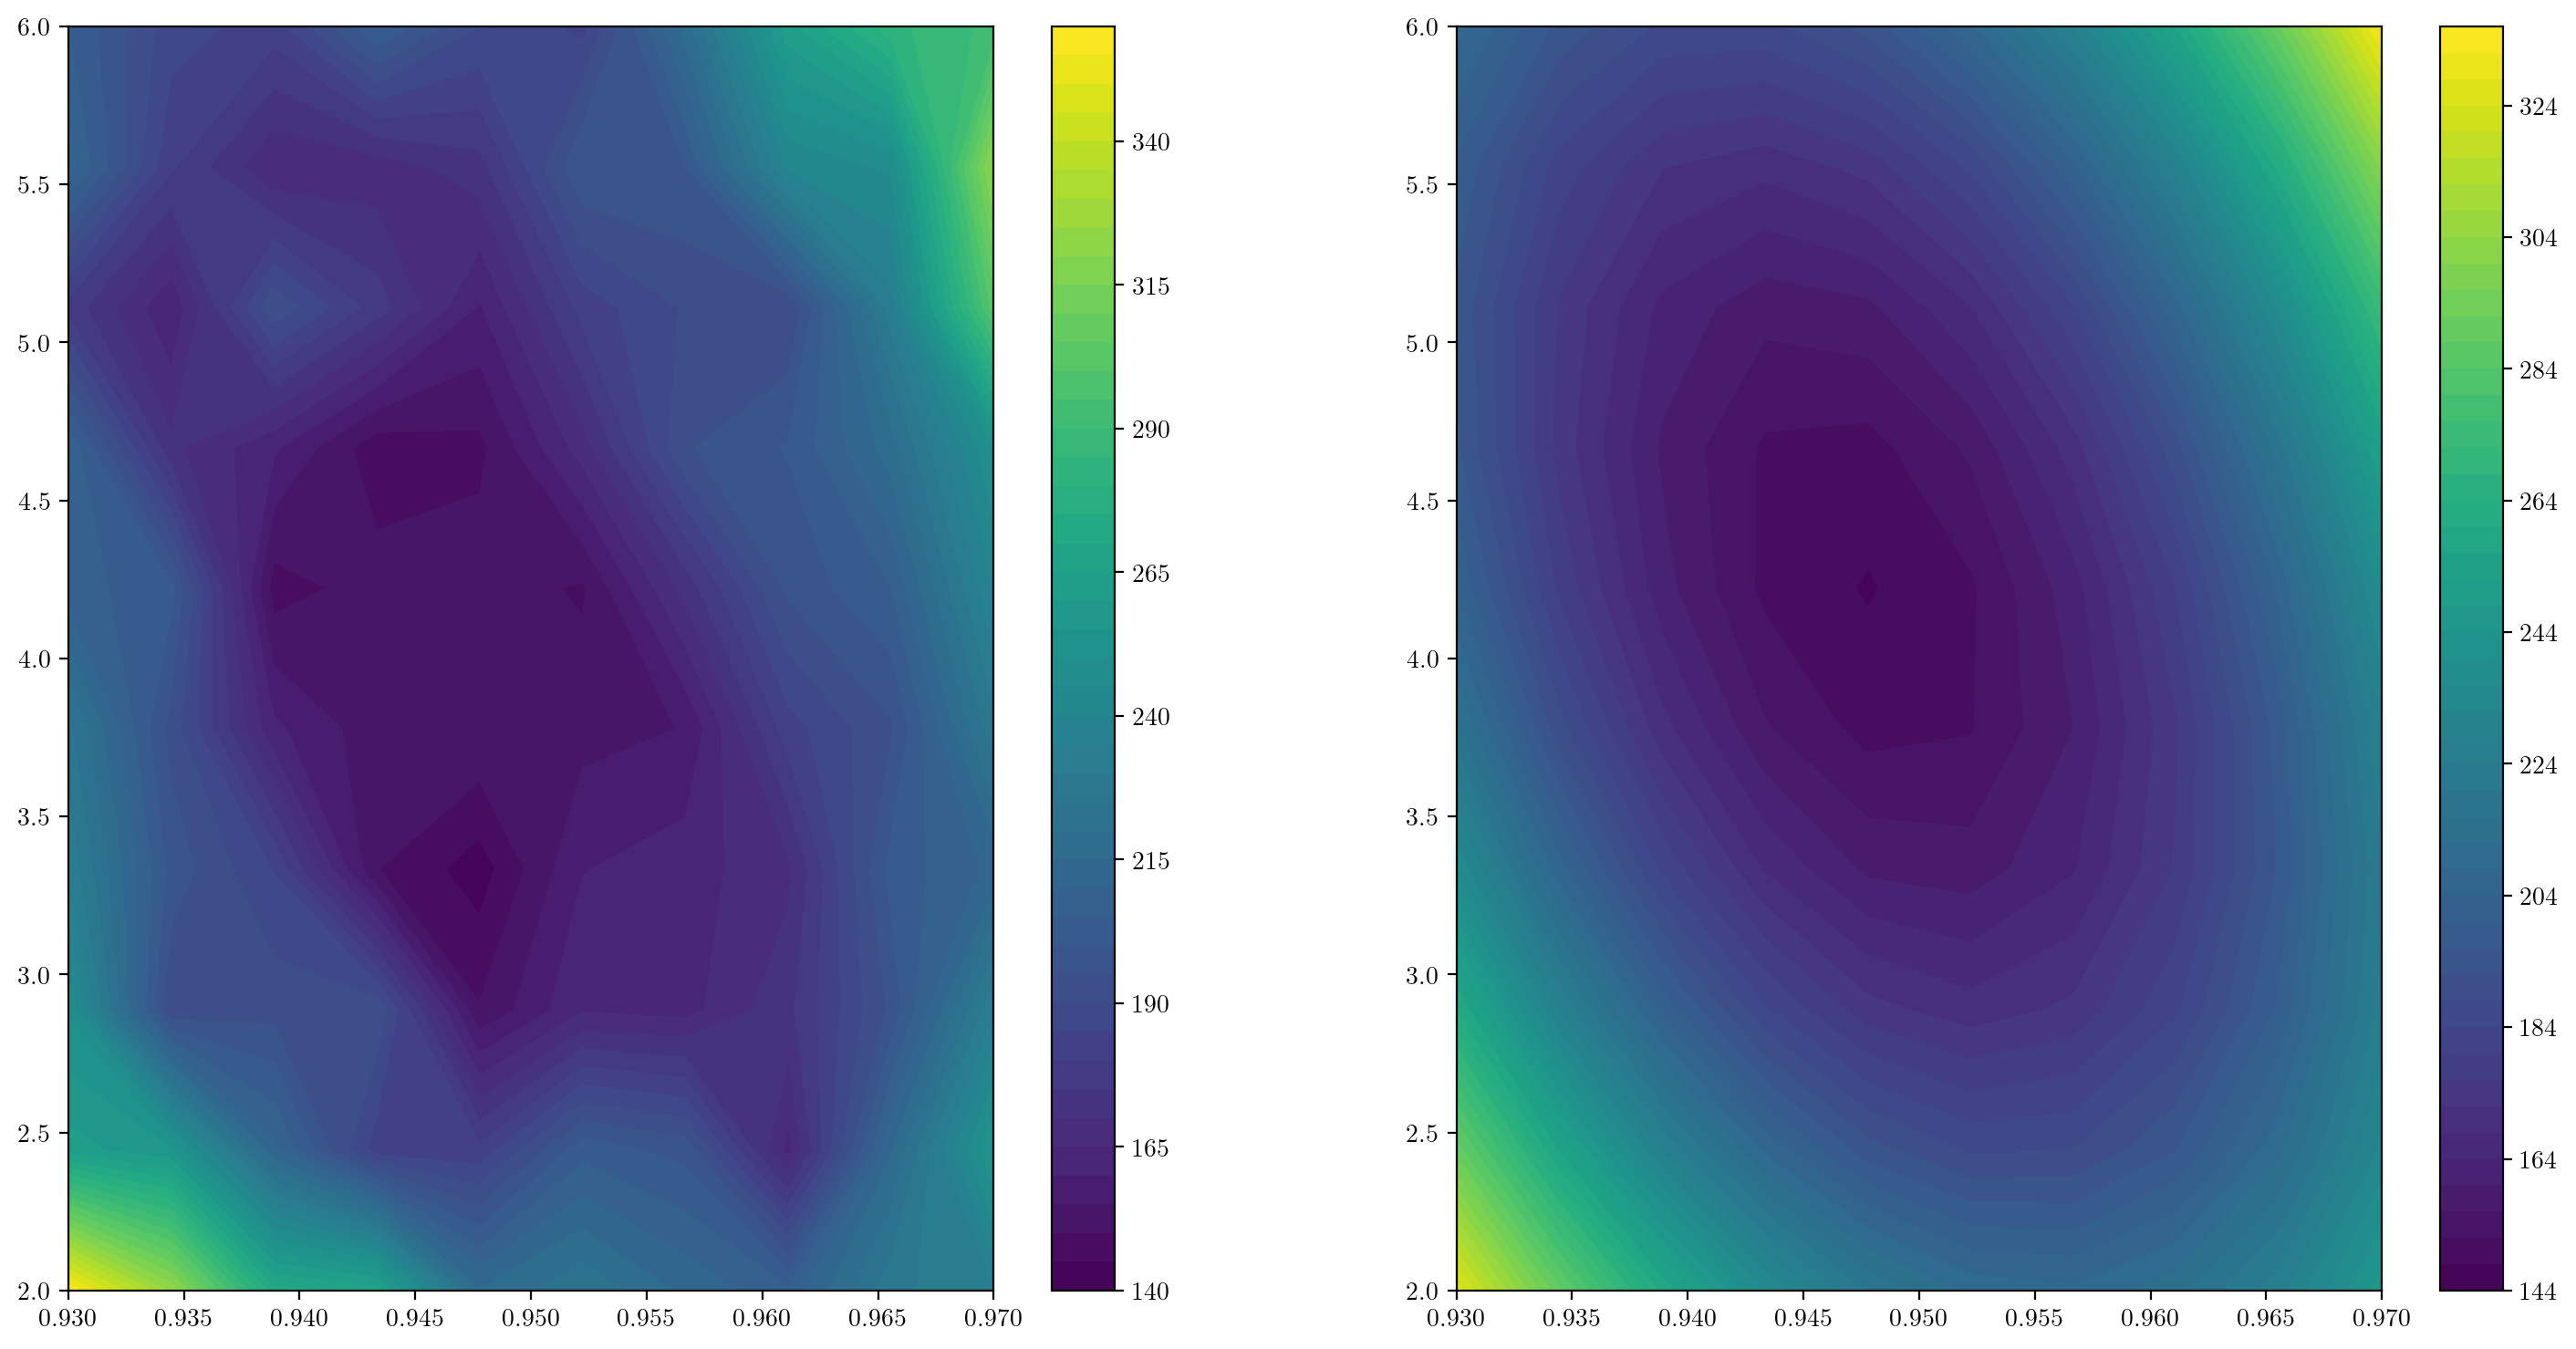

Ly=0.948+/-0.004 PE/keV  F=4.230+/-0.432 (68% CL)


In [167]:
# TOP CHAMBER
data_hist = hist_dif_bot[2]
data_hist_bins = hist_dif_bot_bins[2]
data_hist_err = hist_dif_bot_err[2]

# G4DS SIMULATION
file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")
# file.Close()

# (Ly,F) range
lys = np.linspace(0.93, 0.97, 10)
fanos = np.linspace(2, 6, 10)
X,Y = np.meshgrid(lys, fanos)

fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(18,9)

# Spectrum fit range
norm_min = 200
norm_max = 800
chi2map = np.array([[chisquare_two_hist(ly_, fano_, data_hist, data_hist_bins, data_hist_err, tr, [norm_min,norm_max]) for ly_ in lys] for fano_ in fanos])
cp=ax1.contourf(X, Y, chi2map, 50)
fig.colorbar(cp) # Add a colorbar to a plot
file.Close()

# Fit chi-square to find minimum and errors
popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[0.95, 4, 0.002, 0.2, 0.004, 130], maxfev=10000)
print(*popt)
cp=ax2.contourf(X, Y, gauss2d(np.dstack((X,Y)),*popt), 50)
fig.colorbar(cp)
plt.show()

# Print best fit values and 68% CL
ly_fit = popt[0]
fano_fit = popt[1]
ly_68 = 1.515*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
fano_68 = 1.515*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
print('Ly={:.3f}+/-{:.3f} PE/keV  F={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, fano_fit, fano_68))

174324 events simulated


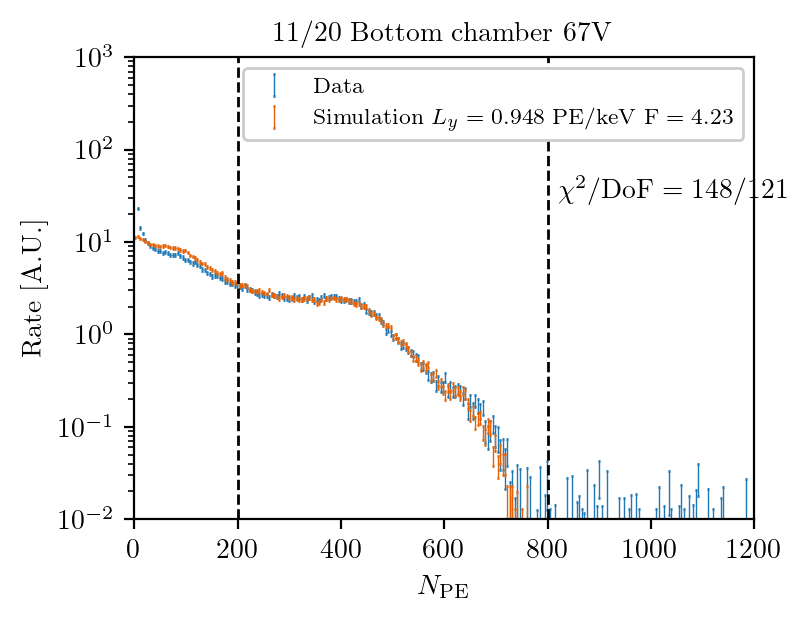

In [168]:
# BOTTOM CHAMBER
data_hist = hist_dif_bot[2]
data_hist_bins = hist_dif_bot_bins[2]
data_hist_err = hist_dif_bot_err[2]

# G4DS SIMULATION
file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
tr = file.Get("trEdep")

simPE = []
nev = 0
for i,ev in enumerate(tr):
    for j in range(1):
        simPE.append(normal(ly_fit*tr.Edep, np.sqrt(fano_fit*ly_fit*tr.Edep)))
        nev += 1
print('{} events simulated'.format(nev))
file.Close()

ymin = 1e-2
ymax = 1e3
xmin = data_hist_bins[0]
xmax = data_hist_bins[-1]
nbins = len(data_hist_bins)-1
bin_width = (xmax-xmin)/nbins
hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
hSimErr = np.sqrt(hSim)
norm = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
hSim = hSim*norm
hSimErr = hSimErr*norm
plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, label='Data', ls='none', capsize=0.5, elinewidth=0.5)
plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}~\rm PE/keV~F={:.2f}$'.format(ly_fit, fano_fit), ls='none', capsize=0.5, elinewidth=0.5)
plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
plt.text(820, 3e1, r'$\chi^2/\rm DoF={:.0f}/{:.0f}$'.format(popt[-1],(norm_max-norm_min)/bin_width-4))
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber 67V')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
file.Close()

Running for bottom 63V
0.78 2.0 793.4675306761698 121
0.7844444444444445 2.0 647.7517620619686 121
0.788888888888889 2.0 482.73163505049706 121
0.7933333333333333 2.0 432.9043720161815 121
0.7977777777777778 2.0 326.71908541874564 121
0.8022222222222223 2.0 301.56535609845827 121
0.8066666666666668 2.0 267.4495305500196 121
0.8111111111111111 2.0 258.8777928456863 121
0.8155555555555556 2.0 281.95753450302857 121
0.8200000000000001 2.0 291.9629454797982 121
0.78 2.4444444444444446 648.3158146763689 121
0.7844444444444445 2.4444444444444446 499.7649526385823 121
0.788888888888889 2.4444444444444446 421.77361155627443 121
0.7933333333333333 2.4444444444444446 337.79948408924594 121
0.7977777777777778 2.4444444444444446 289.6958111322133 121
0.8022222222222223 2.4444444444444446 249.83085499721736 121
0.8066666666666668 2.4444444444444446 218.90015525594376 121
0.8111111111111111 2.4444444444444446 181.47361084946513 121
0.8155555555555556 2.4444444444444446 227.4866590191264 121
0.820000

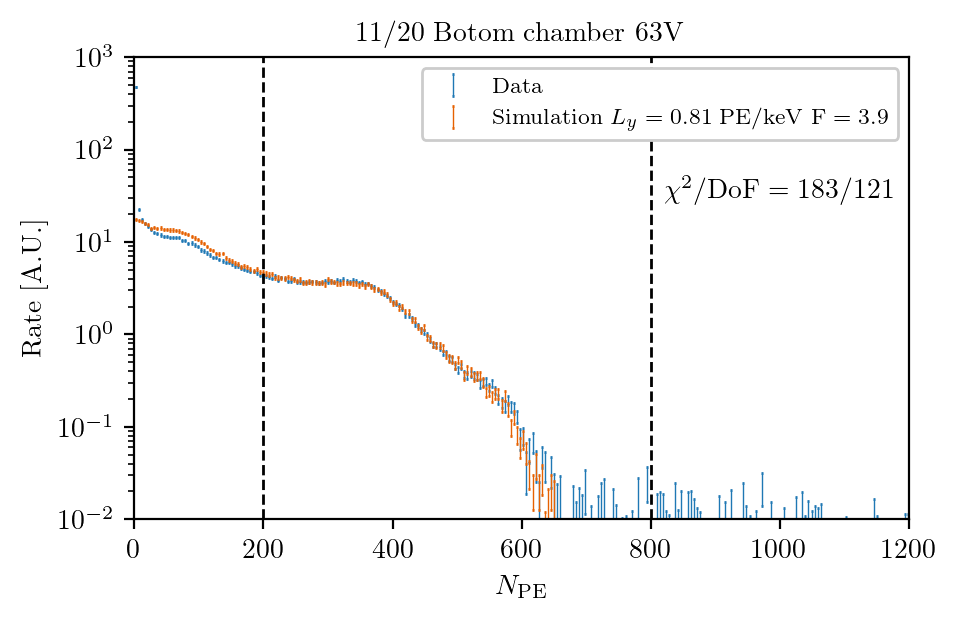

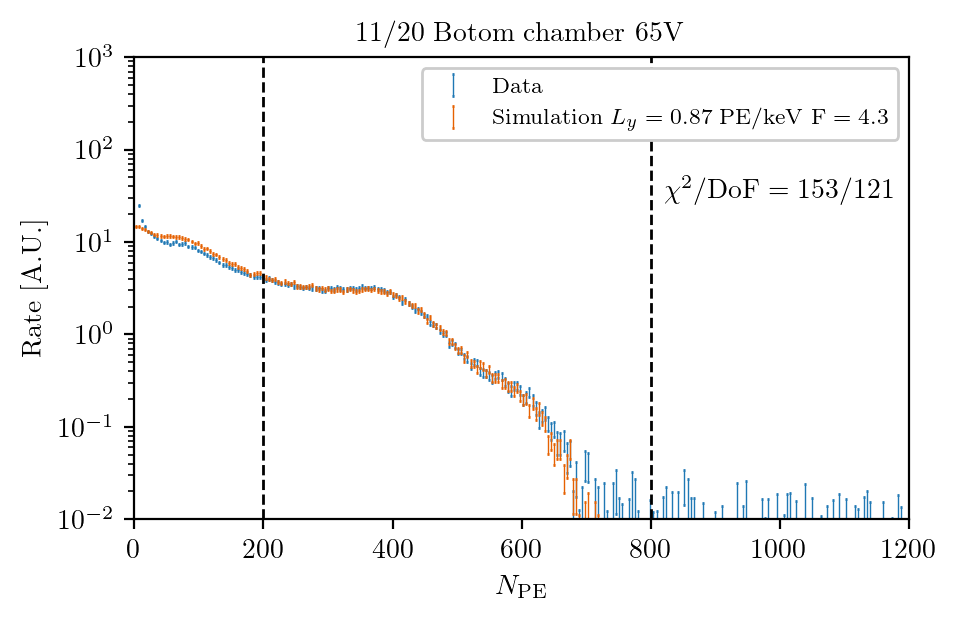

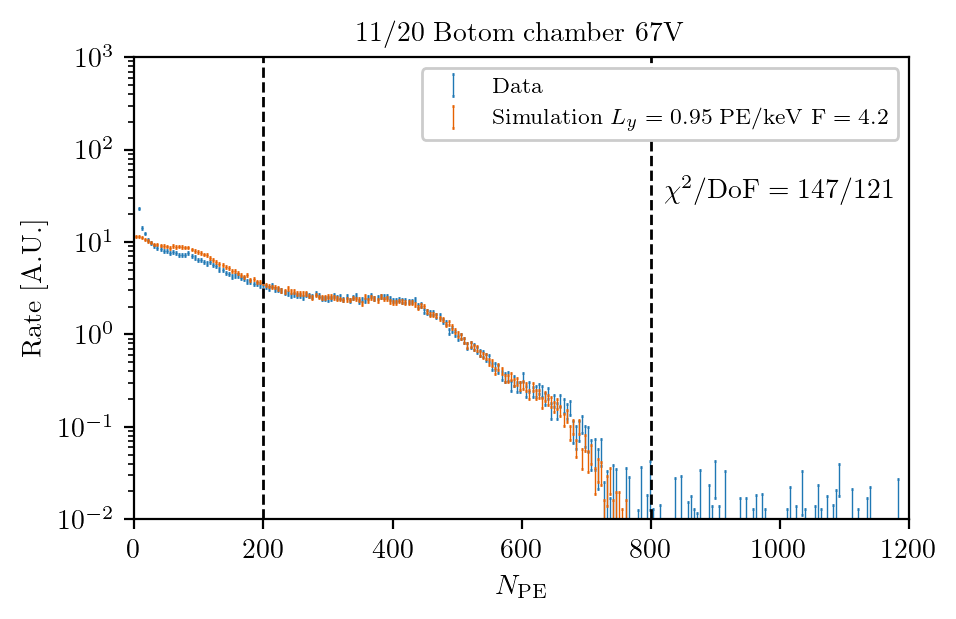

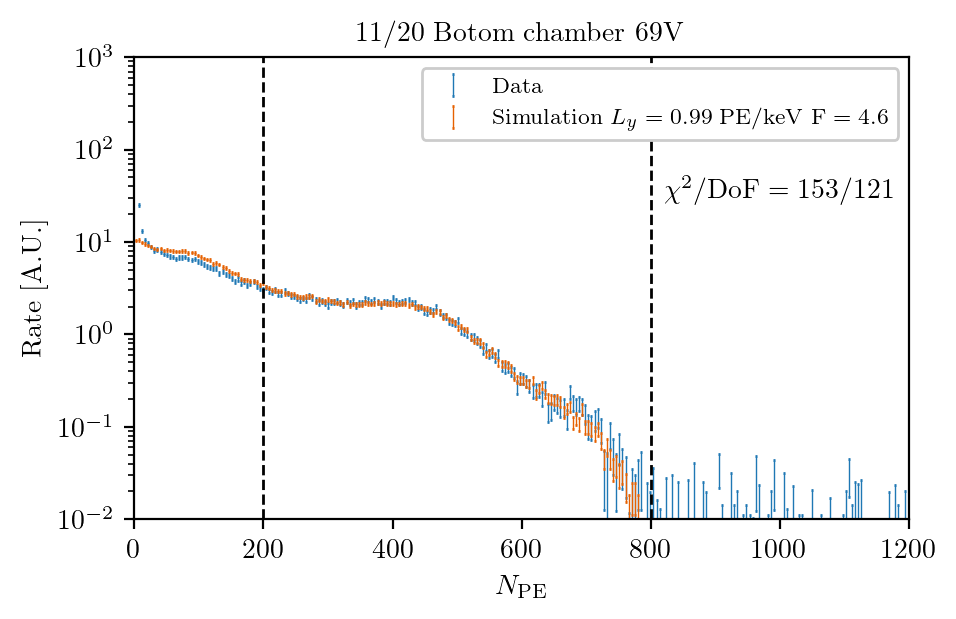

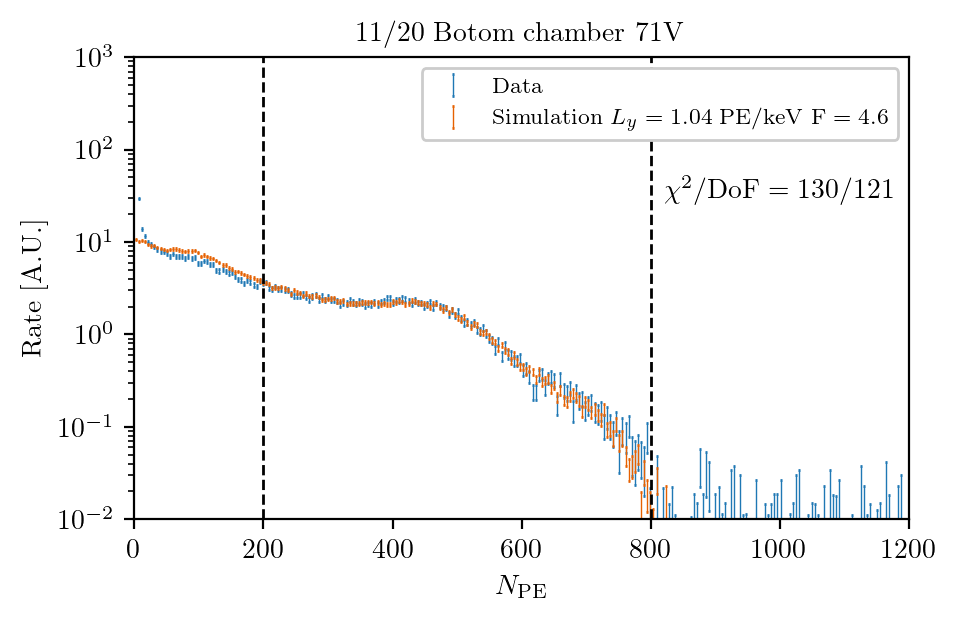

In [169]:
ly_guess = [0.8, 0.87, 0.95, 0.99, 1.03]
ly_bot = []
fano_bot = []
for iv,volt in enumerate(bias):
    print('Running for bottom {}V'.format(volt))
    data_hist = hist_dif_bot[iv]
    data_hist_bins = hist_dif_bot_bins[iv]
    data_hist_err = hist_dif_bot_err[iv]

    file = ROOT.TFile("root/pu_lar_cs137_Edep.root", "read")
    tr = file.Get("trEdep")

    lys = np.linspace(ly_guess[iv]-0.02, ly_guess[iv]+0.02, 10)
    fanos = np.linspace(2, 6, 10)
    X,Y = np.meshgrid(lys, fanos)

    # Spectrum fit range
    norm_min = 200
    norm_max = 800
    chi2map = np.array([[chisquare_two_hist(ly_, fano_, data_hist, data_hist_bins, data_hist_err, tr, [norm_min,norm_max]) for ly_ in lys] for fano_ in fanos])

    # Fit chi-square to find minimum and errors
    popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[ly_guess[iv], 4, 0.002, 0.3, 0.004, 130], maxfev=10000)

    # Print best fit values and 68% CL
    ly_fit = popt[0]
    fano_fit = popt[1]
    ly_68 = 1.515*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
    fano_68 = 1.515*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
    print('Ly={:.3f}+/-{:.3f} PE/keV  F={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, fano_fit, fano_68))
    ly_bot.append([ly_fit, ly_68])
    fano_bot.append([fano_fit, fano_68])
    
    simPE = []
    nev = 0
    for i,ev in enumerate(tr):
        for j in range(1):
            simPE.append(normal(ly_fit*tr.Edep, np.sqrt(fano_fit*ly_fit*tr.Edep)))
            nev += 1
    print('{} events simulated'.format(nev))
    file.Close()

    ymin = 1e-2
    ymax = 1e3
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
    hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
    hSimErr = np.sqrt(hSim)
    norm = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
    hSim = hSim*norm
    hSimErr = hSimErr*norm
    plt.figure(iv,figsize=(5,3))
    plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, label='Data', ls='none', capsize=0.5, elinewidth=0.5)
    plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.2f}~\rm PE/keV~F={:.1f}$'.format(ly_fit, fano_fit), ls='none', capsize=0.5, elinewidth=0.5)
    plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
    plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
    plt.text(820, 3e1, r'$\chi^2/\rm DoF={:.0f}/{:.0f}$'.format(popt[-1],(norm_max-norm_min)/bin_width-4))
    plt.yscale('log')
    plt.ylabel('Rate [A.U.]')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.legend(loc='upper right')
    plt.title('11/20 Botom chamber {}V'.format(volt))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

Text(0.5, 0.98, 'Bottom')

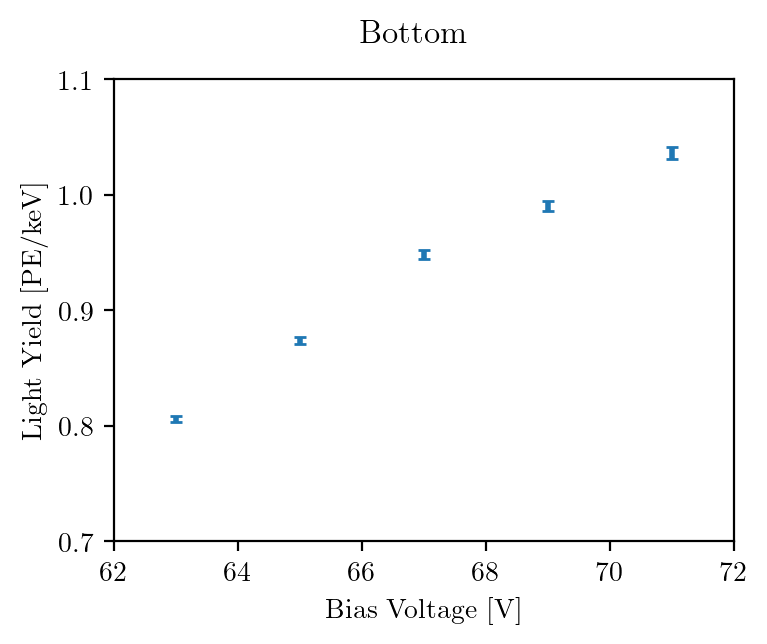

In [170]:
plt.errorbar(bias,np.array(ly_bot)[:,0],yerr=np.array(ly_bot)[:,1], ls='none', elinewidth=2, capsize=2)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.xlim(62,72)
plt.ylim(0.7,1.1)
plt.suptitle('Bottom')

# Top-Bottom Comparison

(5.0, 6.5)

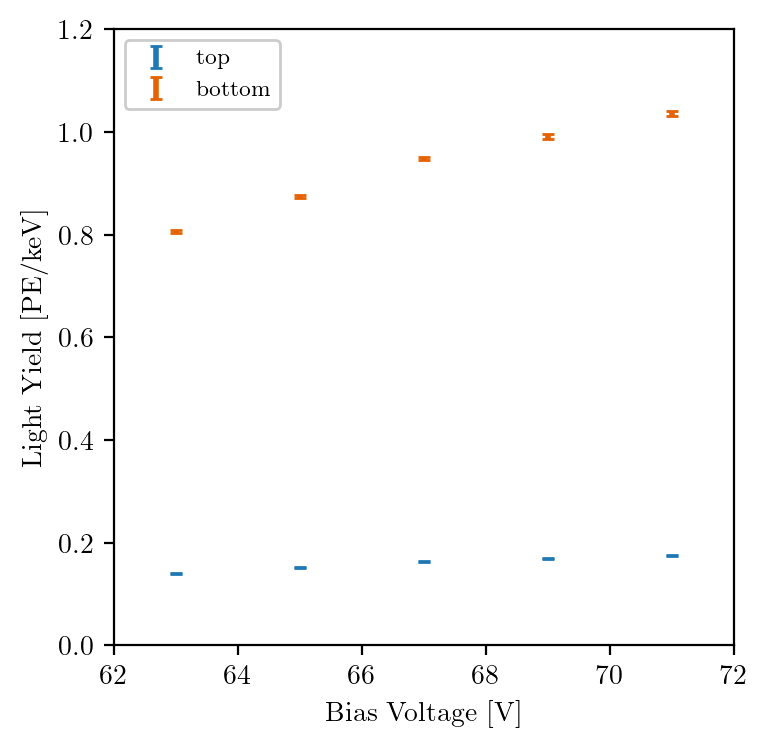

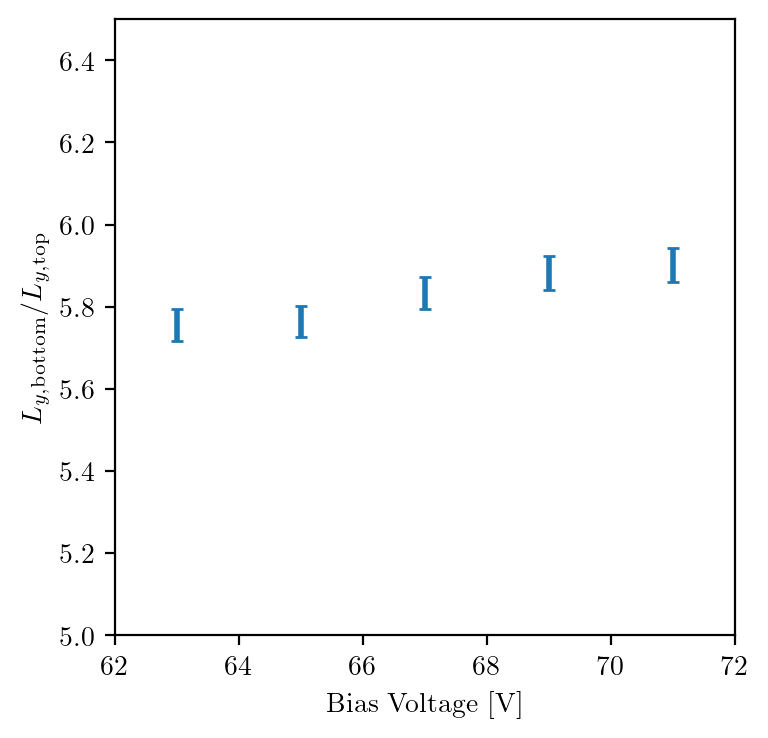

In [171]:
plt.figure(1,figsize=(4,4))
plt.errorbar(bias,np.array(ly_top)[:,0],yerr=np.array(ly_top)[:,1], label='top', ls='none', elinewidth=2, capsize=2)
plt.errorbar(bias,np.array(ly_bot)[:,0],yerr=np.array(ly_bot)[:,1], label='bottom', ls='none', elinewidth=2, capsize=2)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.legend()
plt.xlim(62,72)
plt.ylim(0,1.2)

plt.figure(2,figsize=(4,4))
ly_ratio = np.array(ly_bot)[:,0]/np.array(ly_top)[:,0]
ly_ratio_err = ly_ratio * np.sqrt((np.array(ly_bot)[:,1]/np.array(ly_bot)[:,0])**2+(np.array(ly_top)[:,1]/np.array(ly_top)[:,0])**2)
plt.errorbar(bias,ly_ratio,yerr=ly_ratio_err, ls='none', elinewidth=2, capsize=2)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'$L_{y,\rm bottom}/L_{y,\rm top}$')
plt.xlim(62,72)
plt.ylim(5,6.5)